In [1]:
import os
import functools as ftools
import itertools as itools
import pandas as pd
import polars as pl
import numpy as np

import sgml, dproc, sgnn, sgutil
import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import dill

import seaborn as sns
import matplotlib.pyplot as plt

2024-11-22 08:55:58.190470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732265758.569982    3929 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732265758.693795    3929 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 08:55:59.642919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [3]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

with open(os.path.join('data', 'var_w.dill'), 'rb') as f:
    df_var = dill.load(f)
df_train = pd.read_feather(os.path.join('data', 'train_w.feather'))
sc = sgutil.SGCache('img', 'result')
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target = 'Depression'

In [4]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier)
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)

def show_result_lgb(result):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.barplot(
        pd.concat([i['feature_importance'] for i in result['model_result']], axis=1).mean(axis=1)\
        .sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
        x = 'Importance', y = 'feature', ax=axes[0]
    )
    valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
    sns.lineplot(valid_result, ax=axes[1])
    if 'valid_1' in valid_result:
        axes[1].axvline(valid_result['valid_1'].idxmin())
    plt.tight_layout()
    plt.show()

In [5]:
df_var.sort_values('n_unique', ascending=False)

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
id,0.0,234499.0,0.0,234500.0,117250.0,True,True,False,False,Int32,Int32,None,org,None
Prof_Degree,None,None,0.0,140700.0,602.0,None,None,None,None,None,Categorical,Profession_R2과 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7fed22fe94e0>
Name,None,None,0.0,234500.0,398.0,True,True,True,True,Categorical,Categorical,None,org,None
CGPA_FZ,0.0,10.0,0.0,140700.0,332.0,True,True,True,True,None,Float32,CGPA의 결측을 0으로 채운 변수입니다.,fillna,<function get_fillna_zero_proc.<locals>.<lambd...
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
Name_R,None,None,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Degree,None,None,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,None,org,None
City,None,None,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,None,org,None
Profession,None,None,61262.0,173238.0,65.0,True,True,True,True,Categorical,Categorical,None,org,None
WS_Degree,None,None,0.0,140700.0,56.0,None,None,None,None,None,Categorical,Working Professional or Student와 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7fec6781ce00>


# LGB1

In [6]:
cv_path = os.path.join('result', 'LGB1.cv')
if os.path.exists(cv_path):
    lgb1 = sgml.CVModel.load('result', 'LGB1')
else:
    lgb1 = sgml.CVModel('result', 'LGB1', skf, config, lgb_adapter)

In [7]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'validation_fraction': 0.1
}
result = lgb1.adhoc(df_train, ss, hparams)
show_result_lgb(result)
print(result['valid_scores'])

KeyError: "['Age_2'] not in index"

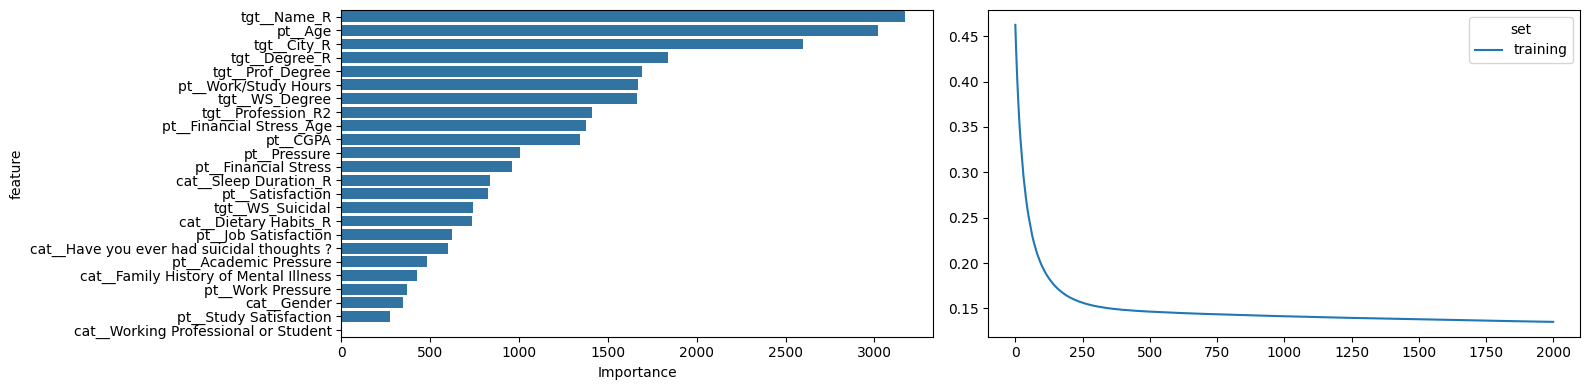

Accuracy, Valid.: 0.94004±0.00140


In [114]:
result = lgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 15, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.7, 'min_child_samples': 4096}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, WS_Suicidal]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


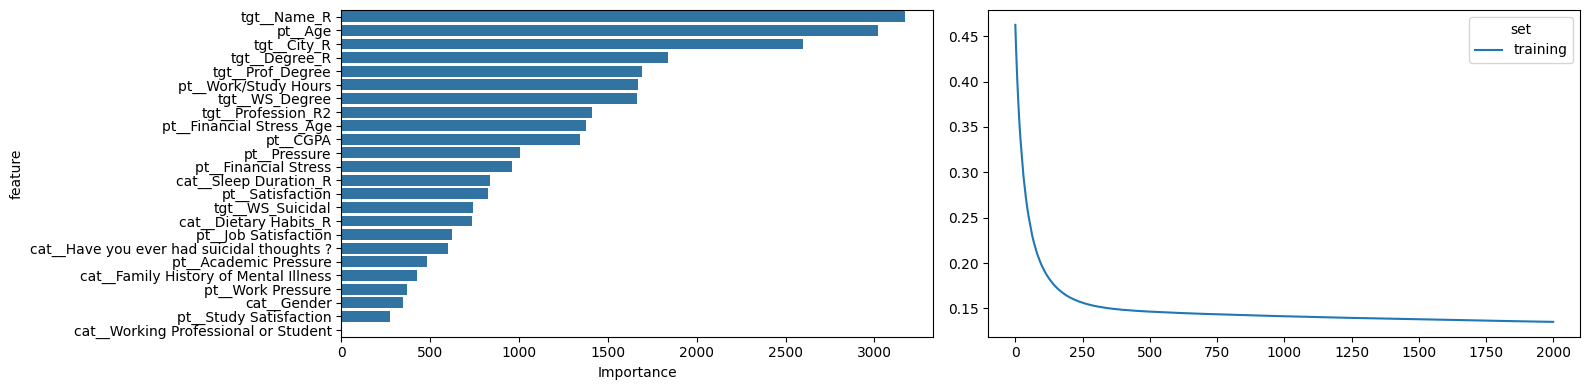

0.9400426439232408


In [115]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(lgb1.get_best_result())
print(lgb1.cv_best_['score'])

# XGB1

In [116]:
cv_path = os.path.join('result', 'XGB1.cv')
if os.path.exists(cv_path):
    xgb1 = sgml.CVModel.load('result', 'XGB1')
else:
    xgb1 = sgml.CVModel('result', 'XGB1', skf, config, xgb_adapter)

In [117]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 3,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R', 'WS_Suicidal'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'ohe': {'drop': 'if_binary'}
}
# xgb1.adhoc(df_train, ss, hparams)

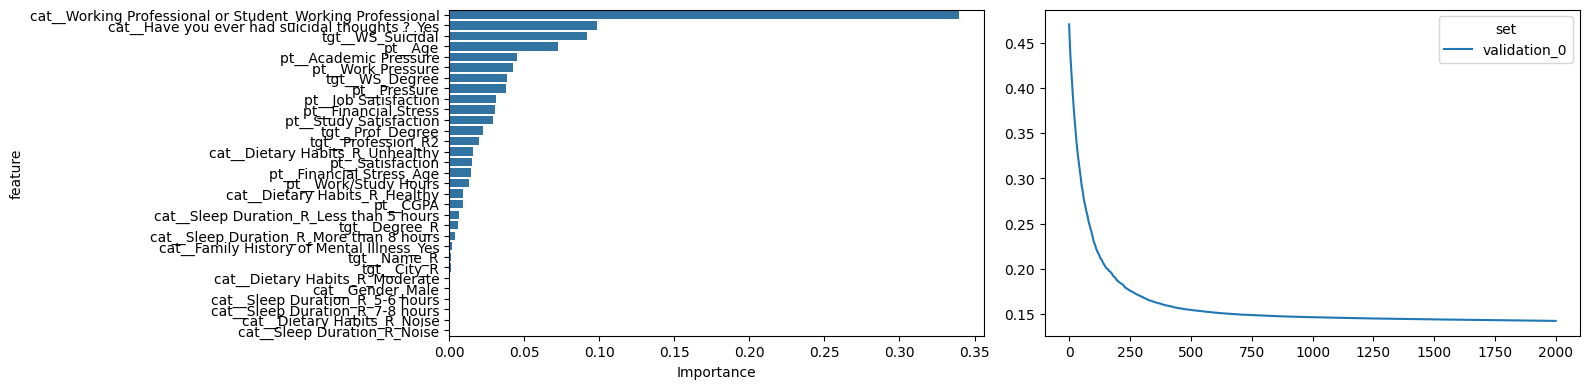

Accuracy, Valid.: 0.93993±0.00174


In [118]:
result = xgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.25}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, WS_Suicidal]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
ohe,{'drop': 'if_binary'}


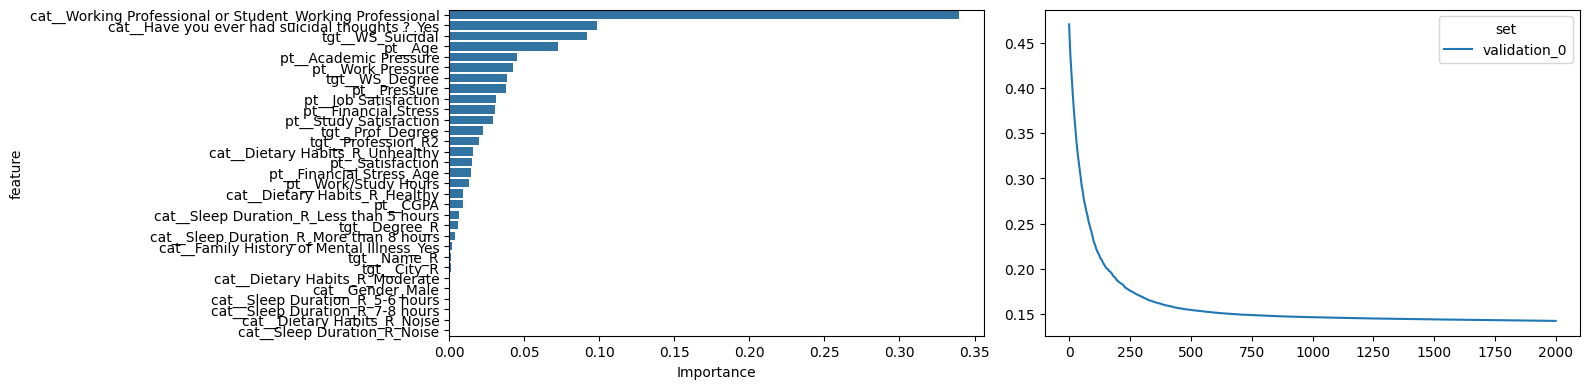

0.9399289267945985


In [119]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# CB

In [120]:
cv_path = os.path.join('result', 'CB1.cv')
if os.path.exists(cv_path):
    cb1 = sgml.CVModel.load('result', 'CB1')
else:
    cb1 = sgml.CVModel('result', 'CB1', skf, config, cb_adapter)

In [121]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 5,
        'learning_rate': 0.05,
        'random_state' : 123,
        'rsm': 0.5
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# cb1.adhoc(df_train, ss, hparams)

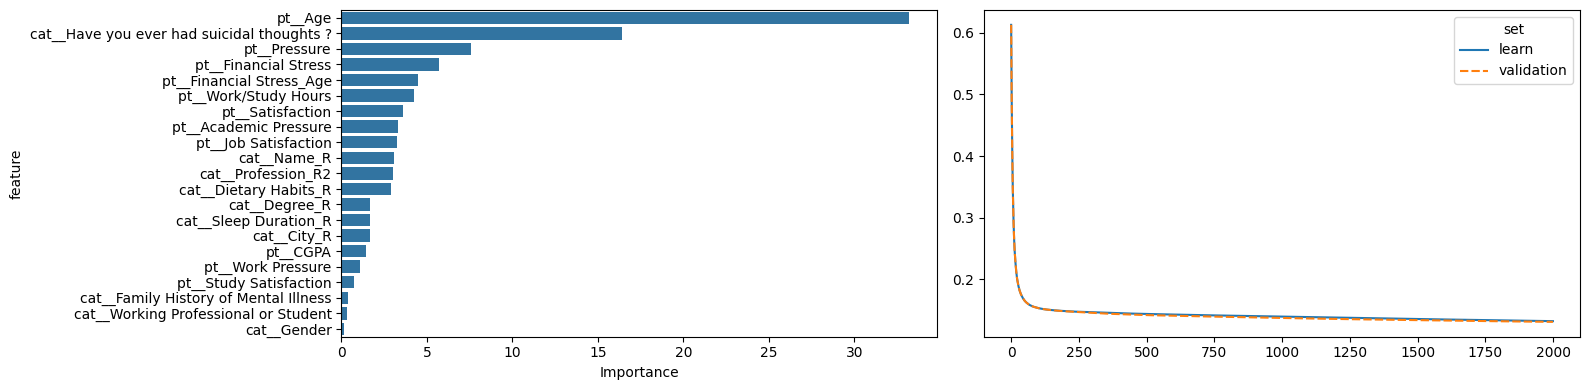

Accuracy, Valid.: 0.94046±0.00173


In [122]:
result = cb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.05, 'random_state': 123, 'rsm': 0.5}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


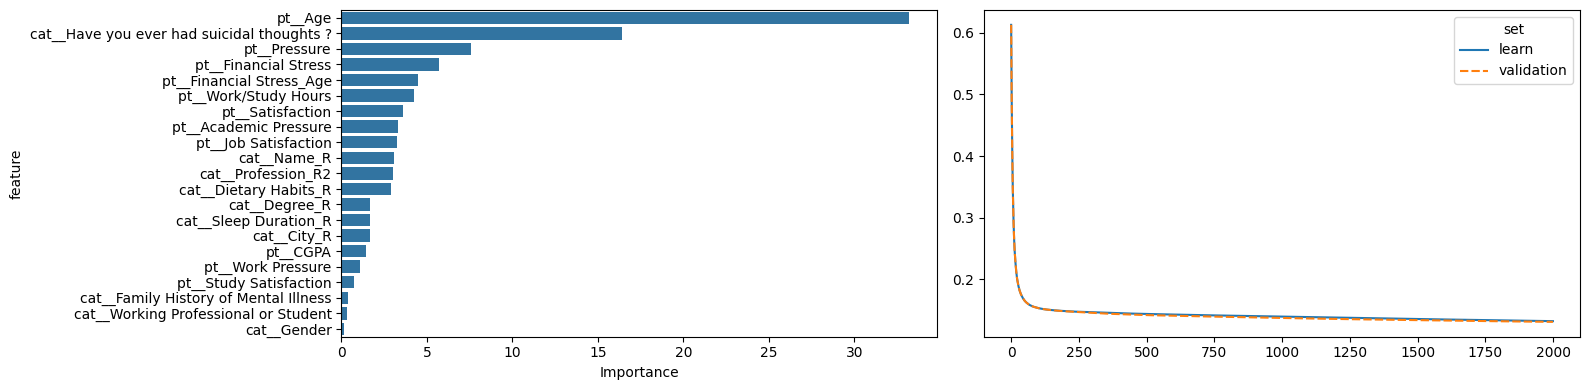

0.9404619758351102


In [123]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(cb1.get_best_result())
print(cb1.cv_best_['score'])

# NN

In [124]:
class DepressionModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v.replace(' ', '_').replace('?', '_'): tf.keras.layers.Embedding(c, s, name=v.replace(' ', '_').replace('?', '_')) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    c = 0
    for i in cat:
        d[i.replace(' ', '_').replace('?', '_')] = np.expand_dims(X[:, c].astype('int'), axis=-1)
        c += 1
        
    if len(cont) > 0:
        d['Continous'] =  X[:, c:]
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size


X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Financial Stress_Age']
X_nn_emb = [
    ('Name_R', 4), ('City_R', 3), ('Profession_R2', 3), ('Degree_R', 3), ('Sleep Duration_R', 2), ('Dietary Habits_R', 2), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_adapter = sgnn.NNAdapter(
    model=sgnn.NNClassifier,
    to_tf_dataset = ftools.partial(
        to_tf_dataset, 
        cont=X_num,
        cat=X_cat
    )
)

In [125]:
cv_path = os.path.join('result', 'NN1.cv')
if os.path.exists(cv_path):
    nn1 = sgml.CVModel.load('result', 'NN1')
else:
    nn1 = sgml.CVModel('result', 'NN1', skf, config, nn_adapter)

In [126]:
nn_params = {
    'emb_cols': [
        nn_cat_param(df_train, v, n) for v, n in X_nn_emb
    ], 
    'cont_cols':  'Continous',
    'f_size':  16, 
    'left_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'right_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 16, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'top_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 1, 'kernel_initializer': 'glorot_uniform'}
    ]
}

hparams = {
    'model_params': {
        'model': DepressionModel, 
        'model_params': nn_params,
        'epochs': 20,
        'optimizer': ('Adam', {'learning_rate': 0.0003}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe': {'drop': 'first'}
}
# nn1.adhoc(df_train, ss, hparams)

In [127]:
result = nn1.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Accuracy, Valid.: 0.93896±0.00140


In [128]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(nn1.cv_best_['hparams']).rename('value').to_frame())
print(nn1.cv_best_['score'])

,value
model_params,"{'model': <class '__main__.DepressionModel'>, 'model_params': {'emb_cols': [('Name_R', 218, 4), ('City_R', 31, 3), ('Profession_R2', 38, 3), ('Degree_R', 28, 3), ('Sleep Duration_R', 5, 2), ('Dietary Habits_R', 4, 2), ('Working Professional or Student', 2, 1), ('Have you ever had suicidal thoughts ?', 2, 1), ('Gender', 2, 1), ('Family History of Mental Illness', 2, 1)], 'cont_cols': 'Continous', 'f_size': 16, 'left_layers': [{'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_unifo..."
X_std,"[CGPA_FZ, Pressure, Satisfaction, Work/Study Hours, Work Pressure_FZ, Academic Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Age, Financial Stress_FM, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R, Sleep Duration_R, Dietary Habits_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness]"
ohe,{'drop': 'first'}


0.9389623312011371


# LGB + LDA

In [129]:
cv_path = os.path.join('result', 'LGB_LDA.cv')
if os.path.exists(cv_path):
    lgb_lda = sgml.CVModel.load('result', 'LGB_LDA')
else:
    lgb_lda = sgml.CVModel('result', 'LGB_LDA', skf, config, lgb_adapter)

In [130]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.9,
        'min_child_samples': 1024
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    }
}
# result = lgb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

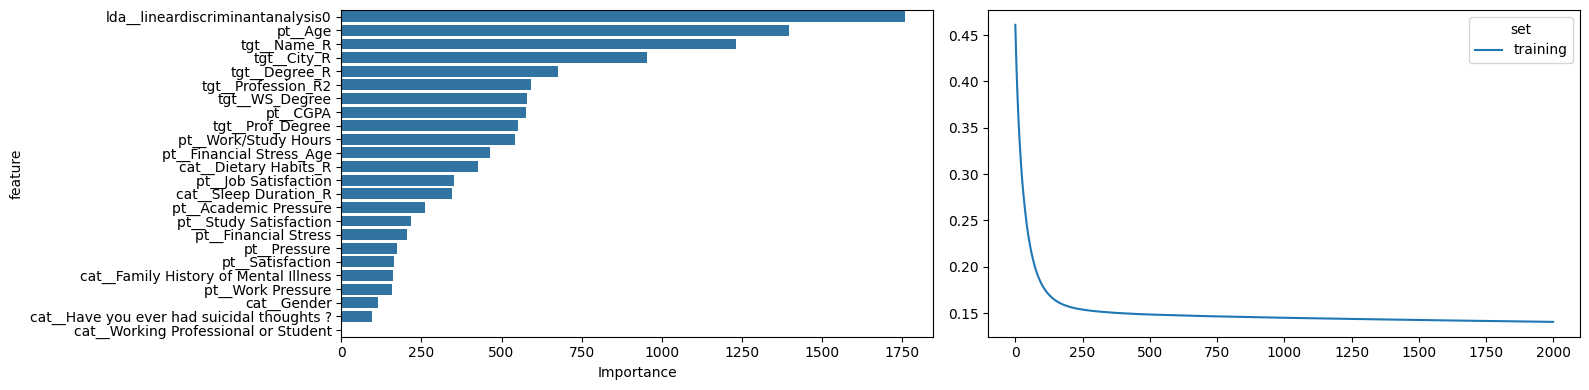

Accuracy, Valid.: 0.93977±0.00156


In [131]:
result = lgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [132]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.9, 'min_child_samples': 1024}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe_drop': 'first'}"


0.9398862828713576


# LGB2

num_leaves를 15 → 7로 낮추어 모델을 구성합니다.

In [133]:
cv_path = os.path.join('result', 'LGB2.cv')
if os.path.exists(cv_path):
    lgb2 = sgml.CVModel.load('result', 'LGB2')
else:
    lgb2 = sgml.CVModel('result', 'LGB2', skf, config, lgb_adapter)

In [134]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.7,
        'min_child_samples': 2048,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# result = lgb2.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

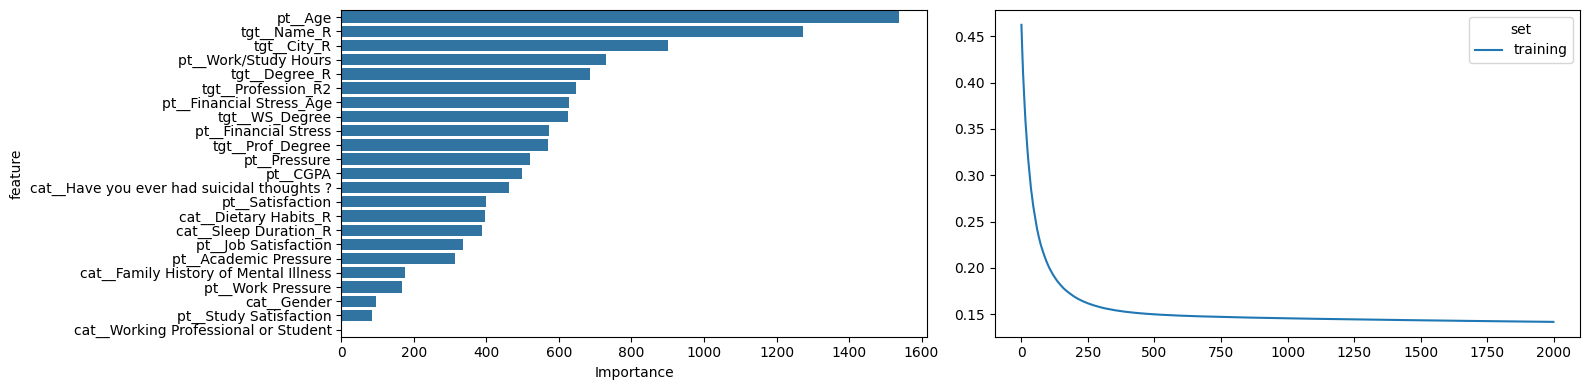

Accuracy, Valid.: 0.93988±0.00123


In [135]:
result = lgb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [136]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb2.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.7, 'min_child_samples': 2048}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9398862828713576


# XGB + LDA

In [137]:
cv_path = os.path.join('result', 'XGB_LDA.cv')
if os.path.exists(cv_path):
    xgb_lda = sgml.CVModel.load('result', 'XGB_LDA')
else:
    xgb_lda = sgml.CVModel('result', 'XGB_LDA', skf, config, xgb_adapter)

In [138]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 3,
        'learning_rate': 0.03,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    }, 'ohe': {'drop': 'if_binary'}
}
# result = xgb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

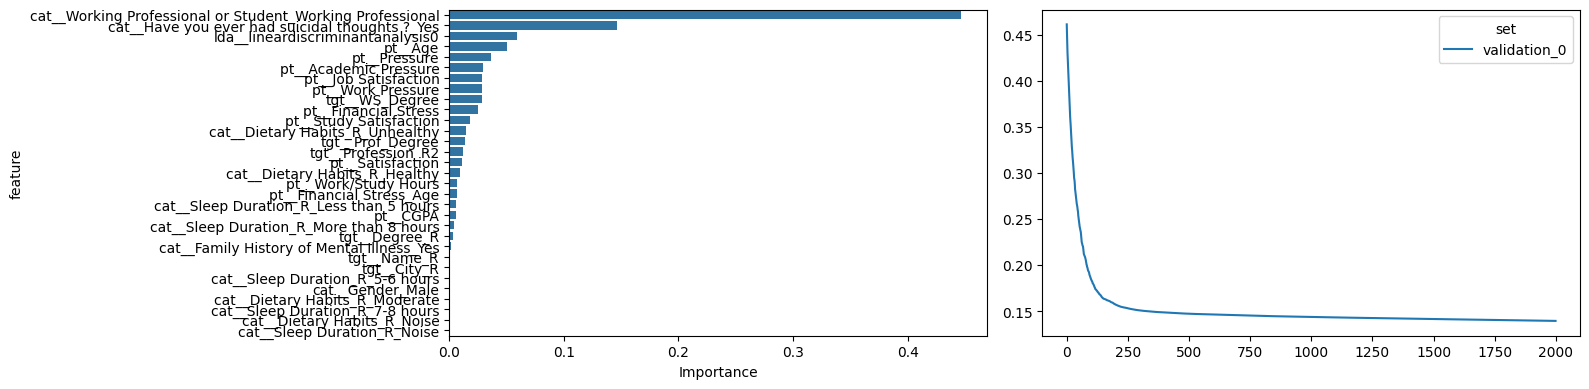

Accuracy, Valid.: 0.93967±0.00162


In [139]:
result = xgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [140]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(xgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.03, 'random_state': 123, 'colsample_bytree': 0.25}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first'}}"
ohe,{'drop': 'if_binary'}


0.9396730632551528


# NN2

In [141]:
cv_path = os.path.join('result', 'NN2.cv')
nn_adapter2 = sgnn.NNAdapter(
    model=sgnn.NNClassifier
)
if os.path.exists(cv_path):
    nn2 = sgml.CVModel.load('result', 'NN2')
else:
    nn2 = sgml.CVModel('result', 'NN2', skf, config, nn_adapter2)

In [142]:
def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Financial Stress_Age']
X_nn_emb = [
    ('Name_R', 4), ('City_R', 3), ('Profession_R2', 3), ('Degree_R', 3), ('Sleep Duration_R', 2), ('Dietary Habits_R', 2), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_params = {
    'embedding':[(1, c, es, 0, 0) for _, c, es in [nn_cat_param(df_train, v, n) for v, n in X_nn_emb]], 
    'config':  [
        {'unit': 64, 'activation': 'relu', 'batch_norm': True},
        {'unit': 32, 'activation': 'relu', 'batch_norm': True, 'dropout': 0.25},
    ]
}

hparams = {
    'model_params': {
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.0003}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe': {'drop': 'first'}
}
# nn2.adhoc(df_train, ss, hparams)

In [143]:
result = nn2.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Accuracy, Valid.: 0.93892±0.00196


# CB2

In [144]:
cv_path = os.path.join('result', 'CB2.cv')
if os.path.exists(cv_path):
    cb2 = sgml.CVModel.load('result', 'CB2')
else:
    cb2 = sgml.CVModel('result', 'CB2', skf, config, cb_adapter)

In [145]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 4,
        'learning_rate': 0.07,
        'random_state' : 123,
        'rsm': 0.75,
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    #'validation_fraction': 0.1
}
#result = cb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['train_scores'], result['valid_scores'])

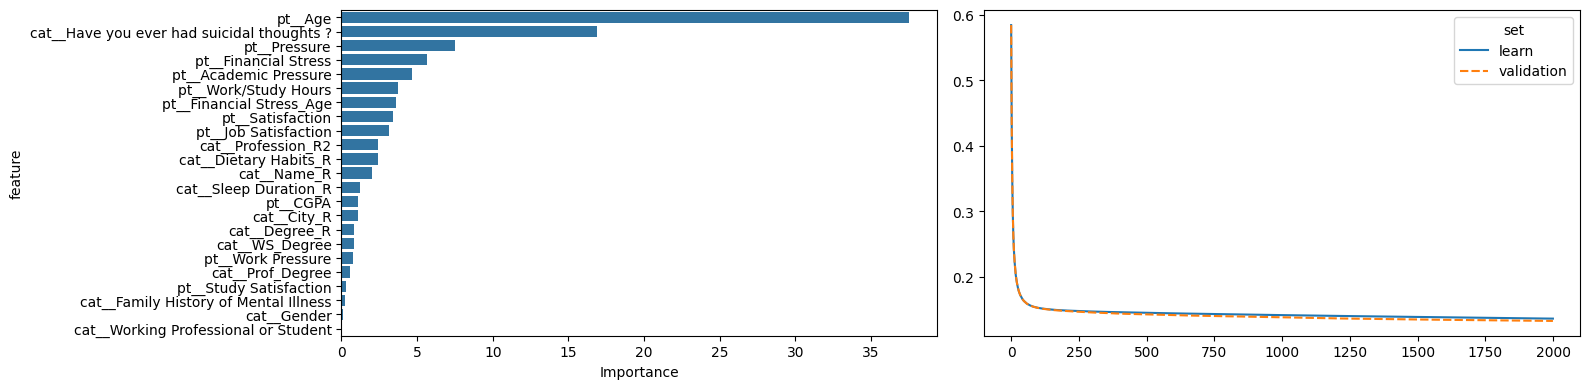

Accuracy, Valid.: 0.94044±0.00178


In [146]:
result = cb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [147]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb2.cv_best_['hparams']).rename('value').to_frame())
print(cb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.07, 'random_state': 123, 'rsm': 0.75}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9404406538734896


# CB3

In [148]:
cv_path = os.path.join('result', 'CB3.cv')
if os.path.exists(cv_path):
    cb3 = sgml.CVModel.load('result', 'CB3')
else:
    cb3 = sgml.CVModel('result', 'CB3', skf, config, cb_adapter)

In [149]:
hparams = {
    'model_params': {
        'n_estimators': 1500, 
        'max_depth': 6,
        'learning_rate': 0.05,
        'l2_leaf_reg': 0.7,
        'rsm': 0.25
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    #'validation_fraction': 0.1
}
# cb3.adhoc(df_train, ss, hparams)

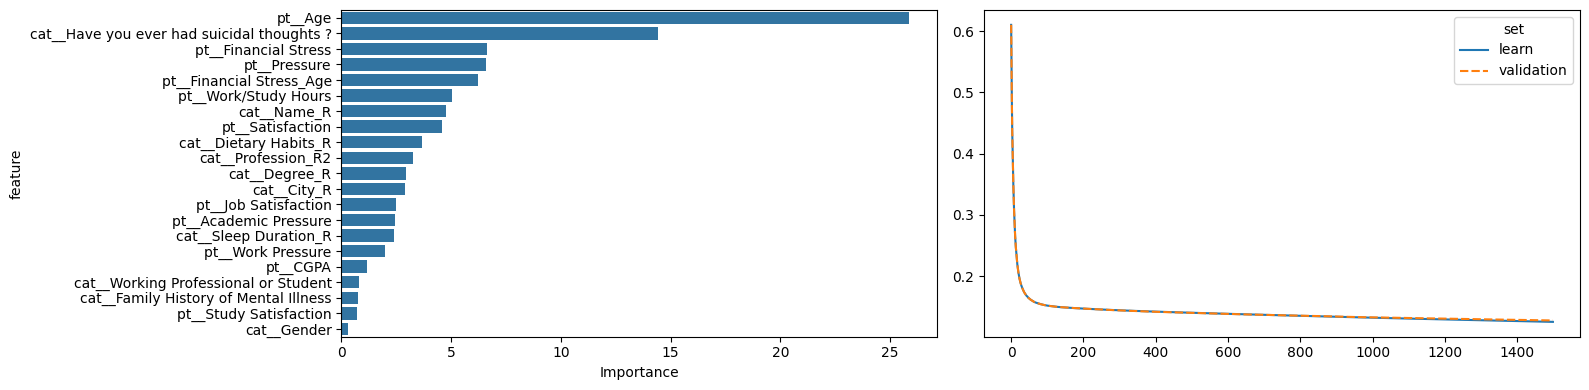

Accuracy, Valid.: 0.94006±0.00157


In [150]:
result = cb3.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# CB + LDA

In [151]:
cv_path = os.path.join('result', 'CB_LDA.cv')
if os.path.exists(cv_path):
    cb_lda = sgml.CVModel.load('result', 'CB_LDA')
else:
    cb_lda = sgml.CVModel('result', 'CB_LDA', skf, config, cb_adapter)

In [152]:
hparams = {
    'model_params': {
        'n_estimators': 2500, 
        'max_depth': 3,
        'learning_rate': 0.07,
        'random_state' : 123,
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree','Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first', 'sparse_output': False}
    },
    #'validation_fraction': 0.1
}
"""result = cb_lda.adhoc(df_train, ss, hparams)
show_result_lgb(result)
print(result['train_scores'], result['valid_scores'])
"""

"result = cb_lda.adhoc(df_train, ss, hparams)\nshow_result_lgb(result)\nprint(result['train_scores'], result['valid_scores'])\n"

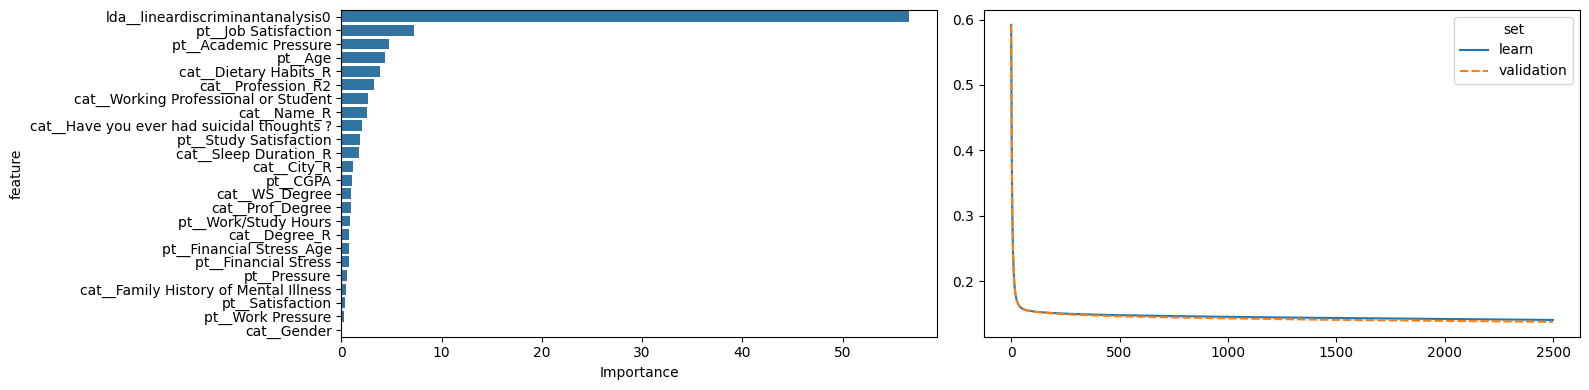

Accuracy, Valid.: 0.94041±0.00172


In [153]:
result = cb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [154]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb2.cv_best_['hparams']).rename('value').to_frame())
print(cb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.07, 'random_state': 123, 'rsm': 0.75}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9404406538734896


# LGB + LDA + TSVD

In [155]:
cv_path = os.path.join('result', 'LGB_LDA_TSVD.cv')
if os.path.exists(cv_path):
    lgb_lda_tsvd = sgml.CVModel.load('result', 'LGB_LDA_TSVD')
else:
    lgb_lda_tsvd = sgml.CVModel('result', 'LGB_LDA_TSVD', skf, config, lgb_adapter)

In [156]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.9,
        'min_child_samples': 1024
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    },
    'tsvd': {'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first'}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}}
}
# result = lgb_lda_tsvd.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

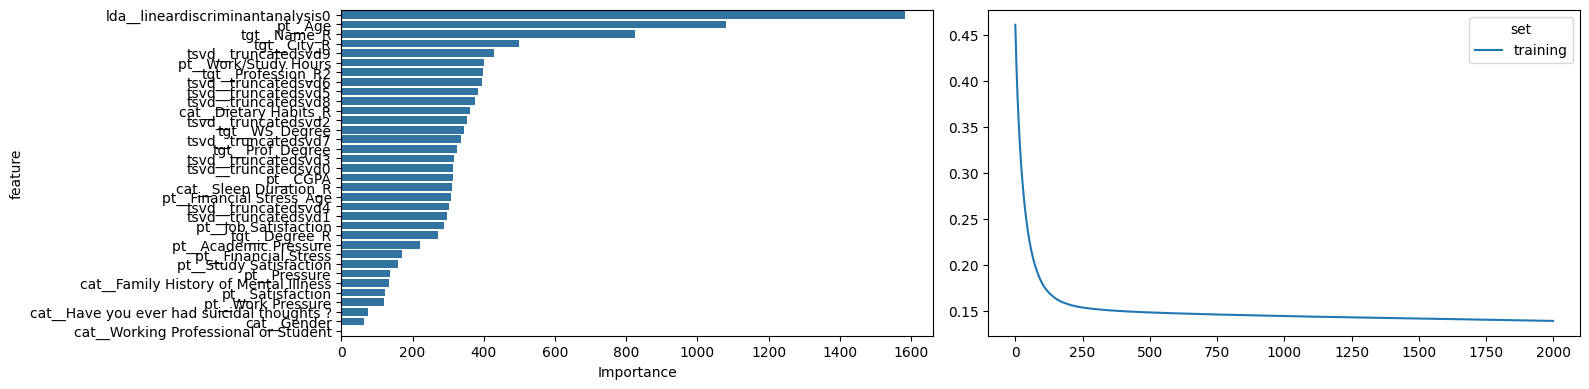

Accuracy, Valid.: 0.93986±0.00181


In [157]:
result = lgb_lda_tsvd.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [158]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb_lda_tsvd.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda_tsvd.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.9, 'min_child_samples': 1024}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first'}}"
tsvd,"{'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first'}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}}"


0.939864960909737


# CB + LDA + TSVD

In [159]:
cv_path = os.path.join('result', 'CB_LDA_TSVD.cv')
if os.path.exists(cv_path):
    cb_lda_tsvd = sgml.CVModel.load('result', 'CB_LDA_TSVD')
else:
    cb_lda_tsvd = sgml.CVModel('result', 'CB_LDA_TSVD', skf, config, cb_adapter)

In [160]:
hparams = {
    'model_params': {
        'n_estimators': 2500, 
        'max_depth': 3,
        'learning_rate': 0.05,
        'random_state' : 123,
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first', 'sparse_output': False}
    },
    'tsvd': {'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first', 'sparse_output': False}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}},
    #'validation_fraction': 0.1
}
# result = cb_lda_tsvd.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

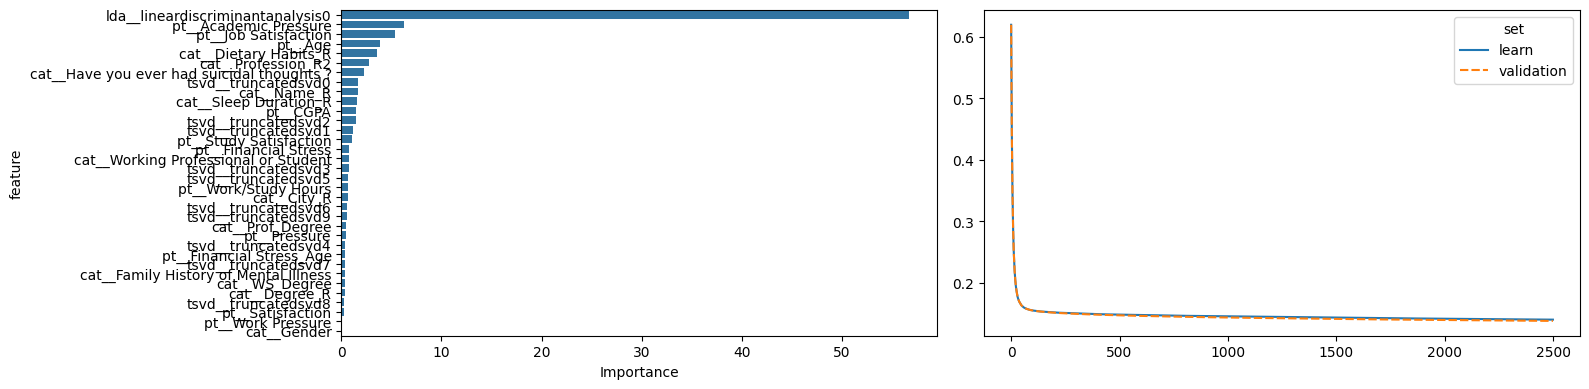

Accuracy, Valid.: 0.93992±0.00182


In [161]:
result = cb_lda_tsvd.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [162]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb_lda_tsvd.cv_best_['hparams']).rename('value').to_frame())
print(cb_lda_tsvd.cv_best_['score'])

,value
model_params,"{'n_estimators': 2500, 'max_depth': 3, 'learning_rate': 0.05, 'random_state': 123}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}}"
tsvd,"{'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first', 'sparse_output': False}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}}"


0.9399218194740582


# XGB + LDA + TSVD

In [163]:
cv_path = os.path.join('result', 'XGB_LDA_TSVD.cv')
if os.path.exists(cv_path):
    xgb_lda_tsvd = sgml.CVModel.load('result', 'XGB_LDA_TSVD')
else:
    xgb_lda_tsvd = sgml.CVModel('result', 'XGB_LDA_TSVD', skf, config, xgb_adapter)

In [164]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 3,
        'learning_rate': 0.03,
        'random_state' : 123,
        'colsample_bytree' : 0.5,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R', 'WS_Suicidal'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'ohe': {'drop': 'if_binary'},
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    },
    'tsvd': {'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first'}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}},
}
# result = xgb_lda_tsvd.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

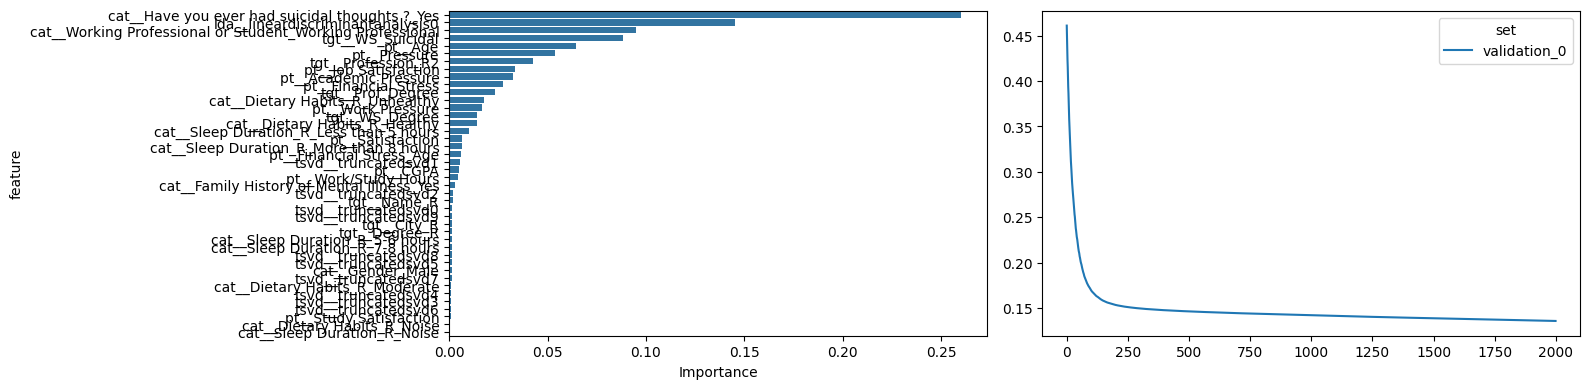

Accuracy, Valid.: 0.93952±0.00182


In [165]:
result = xgb_lda_tsvd.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# Stacking

In [166]:
models = [lgb1, xgb1, cb1, nn1, lgb_lda, lgb2, xgb_lda, nn2, cb2, cb_lda, cb3, lgb_lda_tsvd, cb_lda_tsvd, xgb_lda_tsvd]
pd.Series([i.cv_best_['score'] for i in models], index=[i.name for i in models]).sort_values(ascending=False).to_frame().T

,CB1,CB2,CB_LDA,CB3,LGB1,XGB1,CB_LDA_TSVD,LGB_LDA,LGB2,LGB_LDA_TSVD,XGB_LDA,XGB_LDA_TSVD,NN1,NN2
0,0.940462,0.940441,0.940412,0.940064,0.940043,0.939929,0.939922,0.939886,0.939879,0.939865,0.939673,0.939524,0.938962,0.93892


In [167]:
df_stk = sgml.stack_cv(models, df_train[target]).sort_index()
df_stk.corr()

,LGB1,XGB1,CB1,NN1,LGB_LDA,LGB2,XGB_LDA,NN2,CB2,CB_LDA,CB3,LGB_LDA_TSVD,CB_LDA_TSVD,XGB_LDA_TSVD,Depression
LGB1,1.000000,0.997245,0.995173,0.988751,0.996466,0.997966,0.996923,0.988949,0.994962,0.994818,0.995156,0.995696,0.994354,0.995847,0.837924
XGB1,0.997245,1.000000,0.996698,0.990683,0.997591,0.998420,0.998607,0.990941,0.996656,0.996568,0.996479,0.997056,0.996268,0.997279,0.838812
CB1,0.995173,0.996698,1.000000,0.990380,0.995643,0.995914,0.996327,0.990599,0.998901,0.997979,0.998427,0.995422,0.996861,0.995606,0.839125
NN1,0.988751,0.990683,0.990380,1.000000,0.990215,0.989767,0.990245,0.994937,0.990379,0.990773,0.990009,0.990533,0.990888,0.989955,0.835892
LGB_LDA,0.996466,0.997591,0.995643,0.990215,1.000000,0.997287,0.998007,0.990523,0.995504,0.996359,0.995403,0.998435,0.996089,0.997249,0.838017
LGB2,0.997966,0.998420,0.995914,0.989767,0.997287,1.000000,0.997881,0.989999,0.995740,0.995783,0.995702,0.996631,0.995382,0.996765,0.838230
XGB_LDA,0.996923,0.998607,0.996327,0.990245,0.998007,0.997881,1.000000,0.990415,0.996281,0.996689,0.996017,0.997403,0.996309,0.997653,0.838494
NN2,0.988949,0.990941,0.990599,0.994937,0.990523,0.989999,0.990415,1.000000,0.990569,0.990969,0.990331,0.990776,0.990942,0.990236,0.835794
CB2,0.994962,0.996656,0.998901,0.990379,0.995504,0.995740,0.996281,0.990569,1.000000,0.998241,0.998043,0.995386,0.997026,0.995592,0.839168
CB_LDA,0.994818,0.996568,0.997979,0.990773,0.996359,0.995783,0.996689,0.990969,0.998241,1.000000,0.997213,0.996267,0.998089,0.996149,0.839114


In [168]:
from sklearn.linear_model import LogisticRegression
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

cv_path = os.path.join('result', 'stk_lr.cv')
if os.path.exists(cv_path):
    stk = sgml.CVModel.load('result', 'stk_lr')
else:
    skf2 = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)
    stk = sgml.CVModel('result', 'stk_lr', skf2, config, lr_adapter)

In [169]:
hparams={
    'model_params' : {'C': 10},
    'X_num': ['CB1', 'XGB_LDA', 'CB2', 'CB_LDA', 'NN1', 'CB3', 'XGB1', 'LGB2']
}
result = stk.cv(df_stk, hparams, result_proc=sgml.m_learning_result)
print_metrics('Valid. score', result['valid_scores'])

Accuracy, Valid. score: 0.94038±0.00143


In [170]:
pd.concat(
    [pd.Series(i['model'].coef_[0], index=i['variables']) for i in result['model_result']], axis=1
)

,0,1,2,3,4
CB2,0.879898,0.806890,0.867095,0.851813,0.871509
XGB1,0.899832,0.998278,0.951256,0.945308,1.098573
LGB2,0.349182,0.250403,0.363692,0.419630,0.268167
CB3,0.871820,0.975163,0.894797,0.892501,0.759087
CB_LDA,0.836314,0.816376,0.787782,0.859234,0.879808
CB1,0.892790,0.810880,0.829557,0.754669,0.751678
NN1,2.046913,2.034581,1.912435,2.018511,1.995753
XGB_LDA,0.623649,0.717507,0.791273,0.674336,0.777920


In [ ]:
df_true = df_train.loc[
    (stk.cv_best_['prd'].sort_index() > 0.5) == df_train[target]
]
df_false = df_train.loc[
    (stk.cv_best_['prd'].sort_index() > 0.5) != df_train[target]
].assign(
    y_proba = stk.cv_best_['prd']
)

In [99]:
df_diff_0 = pd.concat([
    df_true.loc[df_true[target] == 0],
    df_false.loc[df_false[target] == 1].drop(columns='y_proba')
])
df_diff_0[target].value_counts(normalize=True)

Depression
0    0.957109
1    0.042891
Name: proportion, dtype: float64

In [313]:
from sklearn.metrics import roc_auc_score
for train_idx, test_idx in skf.split(df_diff_0, df_diff_0[target]):
    df_cv_train, df_valid = df_diff_0.iloc[train_idx], df_diff_0.iloc[test_idx]
    s_mean = df_cv_train.assign(Age_2=lambda x: x['Age'] <= 33).groupby(['WS_Suicidal', 'Age_2'], observed=True)[target].mean()
    print(
        roc_auc_score(df_valid[target], df_valid.assign(Age_2=lambda x: x['Age'] <= 33)[['WS_Suicidal', 'Age_2']].apply(tuple,axis=1).map(s_mean))
    )

0.8400469156363747
0.846488820561569
0.8480548522641519
0.8420149633618669
0.847308604267974


In [384]:
for i in range(30, 40):
    print(i, roc_auc_score(df_train[target], df_train.assign(Age_2=lambda x: x['Age'] <= i).groupby(['Have you ever had suicidal thoughts ?', 'Age_2'], observed=True)[target].transform('mean')))

30 0.8995235710279785
31 0.9087643574792981
32 0.9163950391990906
33 0.9238952858073817
34 0.9259590138387608
35 0.9209586833104242
36 0.9160076764786189
37 0.9118812256457018
38 0.9029634301755942
39 0.8965842553616641


In [373]:
roc_auc_score(
    df_train[target], df_train.assign(Age_2=lambda x: x['Age'] <= 33).groupby(
        ['WS_Suicidal', 'Age_2', 'Pressure', 'Satisfaction', 'Financial Stress_FM'], observed=True
    )[target].transform('mean')
)

0.9674469007829937

In [385]:
accuracy_score(df_train[target], df_train.assign(Age_2=lambda x: x['Age'] <= 34).groupby(['Have you ever had suicidal thoughts ?', 'Age_2'], observed=True)[target].transform('mean') > 0.5)

0.9060341151385928

In [369]:
df_train2 = df_train.assign(
    Age_2 = lambda x: x['Age'] <=33
)

In [342]:
from sklearn.metrics import roc_auc_score
X = ['WS_Suicidal', 'Age_2', 'Pressure', 'Satisfaction', 'Financial Stress']
for train_idx, test_idx in skf.split(df_diff_0, df_diff_0[target]):
    df_cv_train, df_valid = df_diff_0.iloc[train_idx], df_diff_0.iloc[test_idx]
    s_mean = df_cv_train.assign(Age_2=lambda x: x['Age'] <= 33).groupby(X, observed=True)[target].mean()
    print(
        roc_auc_score(df_valid[target], df_valid.assign(Age_2=lambda x: x['Age'] <= 33)[X].apply(tuple,axis=1).map(s_mean).fillna(df_cv_train[target].mean()))
    )

0.8739850816267978
0.8809470248779452
0.8783251394303117
0.8722637499051114
0.874560788936668


In [370]:
from sklearn.model_selection import cross_val_score
cross_val_score(
    LogisticRegression(), pd.get_dummies(df_train2[['WS_Suicidal', 'Age_2', 'Pressure', 'Satisfaction', 'Financial Stress_FM']], columns=['WS_Suicidal'], drop_first=True), df_train2[target], 
    scoring='accuracy', cv=skf
)

array([0.92484009, 0.92963753, 0.92828714, 0.92942431, 0.92690121])

In [236]:
from sklearn.metrics import roc_auc_score
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 5,
        'learning_rate': 0.05,
        'random_state' : 123,
        'rsm': 0.5
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
result = sc.cache_result(
    'cb_diff_0',
    lambda : sgml.cv(df_diff_0, skf, hparams, config, cb_adapter)
)
roc_auc_score(df_diff_0[target], result['valid_prd'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

0.5749773320665317

In [237]:
df_importance = pd.concat([i['feature_importance'] for i in result['model_result']], axis=1).sum(axis=1).sort_values(ascending=False)
df_importance.iloc[:30]

pt__Age                                       160.663633
cat__Have you ever had suicidal thoughts ?     77.579784
pt__Pressure                                   37.004070
pt__Financial Stress                           31.143880
pt__Financial Stress_Age                       29.613695
pt__Work/Study Hours                           24.186218
pt__Satisfaction                               22.847939
cat__Name_R                                    16.299856
pt__Job Satisfaction                           14.477637
cat__Profession_R2                             13.716595
cat__Dietary Habits_R                          11.979698
cat__Degree_R                                  11.575569
cat__City_R                                     8.988048
pt__Work Pressure                               8.180156
pt__CGPA                                        7.687985
cat__Sleep Duration_R                           7.206918
pt__Academic Pressure                           6.474282
pt__Study Satisfaction         

In [102]:
df_diff_1 = pd.concat([
    df_true.loc[df_true[target] == 1],
    df_false.loc[df_false[target] == 0].drop(columns='y_proba')
])
df_diff_1[target].value_counts(normalize=True)

Depression
1    0.858772
0    0.141228
Name: proportion, dtype: float64

In [225]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 15,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.7,
        'min_child_samples': 64,
    }, 
    'X_ohe': ['Name_R', 'City_R'],
    'X_tgt': ['Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R', 'WS_Suicidal'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
result = sc.cache_result(
    'lgb_diff_1',
    lambda : sgml.cv(df_diff_1, skf, hparams, config, lgb_adapter)
)
roc_auc_score(df_diff_1[target], result['valid_prd'])

0.5159306694654591

In [308]:
from sklearn.metrics import roc_auc_score
for train_idx, test_idx in skf.split(df_diff_1, df_diff_1[target]):
    df_cv_train, df_valid = df_diff_1.iloc[train_idx], df_diff_1.iloc[test_idx]
    s_mean = df_cv_train.assign(Age35=lambda x: x['Age'] <= 35).groupby(['WS_Suicidal', 'Age35'], observed=True)[target].mean()
    print(
        roc_auc_score(df_valid[target], df_valid.assign(Age35=lambda x: x['Age'] <= 35)[['WS_Suicidal', 'Age35']].apply(tuple,axis=1).map(s_mean).fillna(df_diff_1[target].mean()))
    )

0.575184227718555
0.5916388100637764
0.5737722109340824
0.5804572560034996
0.5652401759590852


In [293]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_stk[target], df_stk[['LGB2', 'CB1', 'XGB_LDA', 'CB2', 'CB_LDA', 'NN1', 'CB3', 'XGB1', 'LGB_LDA_TSVD']].mean(axis=1))

0.9761781647981894

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_stk[target], df_stk[['LGB2', 'CB1', 'NN1', 'XGB1', 'XGB_LDA', 'CB2', 'CB_LDA', 'CB_LDA_TSVD']].mean(axis=1))

In [ ]:
accuracy_score(df_stk[target], (df_stk[['CB1', 'NN1', 'CB_LDA']].mean(axis=1) > 0.5))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_stk[target], df_stk[['CB1', 'CB2', 'NN1', 'LGB2']].mean(axis=1))

In [ ]:
for i in models:
    i.train(df_train)

In [ ]:
df_test = pl.read_parquet(files['test_parquet'])
df_test = df_test.to_pandas().set_index('id')

In [ ]:
df_test, nq = dproc.apply_pd_procs(df_test, df_var.loc[df_var['processor'].notna(), 'processor'])
df_test

In [ ]:
df_stk_test = sc.cache_result(
    'stk_test',
    lambda : sgml.stack_prd(models, df_test, config)
)
df_stk_test.head()

In [ ]:
stk.train(df_stk)

In [ ]:
stk.get_predictor()(df_stk_test)